In [1]:
%load_ext memory_profiler
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
#from glob import glob
from pathlib import Path
import os

import numpy as np
import xarray as xr
from xorca.lib import load_xorca_dataset

In [2]:
from dask.distributed import Client, LocalCluster, wait
# Start a local cluster with 4 single-threaded (HDF is triggering errors
# if they are multi-threaded) workers which get only 1500 MiB of memory each.
cluster = LocalCluster(n_workers=4, threads_per_worker=1, memory_limit=1500e6,
                       silence_logs=50)
client = Client(address=cluster)
client

Client Scheduler: tcp://127.0.0.1:53332 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 5.59 GiB


## Load data

In [3]:
data_path = Path("/Users/nlahaye/tmp/eNATL60")

data_fname = "eNATL60NOE-BLBT02_y2009m07d0?.1h_vo*_0-botm.nc"
ssh_fname = "eNATL60NOE-BLBT02_y2009m07we1.1h_ssh.nc"
grid_fname = "m*_eNATL60NOE_3.6.nc"
topo_fname = 'eNATL60NOE_BATHY_GEBCO_2014_2D_msk_v3.1_lb.nc4'

data_files = list(data_path.glob(data_fname))+[data_path/ssh_fname]
grid_files = list(data_path.glob(grid_fname))

In [4]:
%%time
%%memit
ds_tot = load_xorca_dataset(data_files=data_files, aux_files=grid_files,
                              decode_cf=True, model_config="nest"
                             )
# add bathymetry
ds_bot = xr.open_dataset(data_path/topo_fname)
ds_tot = ds_tot.assign_coords(topo = ds_bot.Bathymetry.rename({"x":"x_c", "y":"y_c"}))
print("dataset is {:.1f} GB".format(ds_tot.nbytes/1e9))

dataset is 7.0 GB
peak memory: 204.30 MiB, increment: 68.06 MiB
CPU times: user 3.26 s, sys: 165 ms, total: 3.42 s
Wall time: 7.26 s


In [91]:
ds_tot

<xarray.Dataset>
Dimensions:   (t: 168, x_c: 121, x_r: 121, y_c: 139, y_r: 139, z_c: 300, z_l: 300)
Coordinates: (12/34)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 136.5 137.5 138.5 139.5
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 ... 118.5 119.5 120.5 121.5
    ...        ...
    e3w       (z_l, y_c, x_c) float64 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    tmask     (z_c, y_c, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    umask     (z_c, y_c, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vmask     (z_c, y_r, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    fmask     (z_c, y_r, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    topo      (y_c, x_c) float32 ...
Data variables:
    sossheig  (t, y_c, x_c) float32 dask.array<chunksize=(1, 139, 121), meta=np.ndarray>
    vosaline  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    votemper  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>

### Load base grid and moving grid
Warning: need to rename some dimensions

In [5]:
### Grid at rest. Keep "z" dim as is, because it is both on T and W levels
ds_gro = xr.open_dataset(data_path/grid_fname.replace("*","esh_zgr")).squeeze()
ds_gro = ds_gro.get(["e3t_0", "e3t_1d", "e3w_0", "e3w_1d", "gdept_0", 
                     "gdept_1d", "gdepw_0", "gdepw_1d", "mbathy", "nav_lat", "nav_lon", "nav_lev"])\
            .rename({"x":"x_c", "y":"y_c"})
ds_gro

<xarray.Dataset>
Dimensions:   (x_c: 121, y_c: 139, z: 300)
Dimensions without coordinates: x_c, y_c, z
Data variables:
    e3t_0     (z, y_c, x_c) float64 ...
    e3t_1d    (z) float64 ...
    e3w_0     (z, y_c, x_c) float64 ...
    e3w_1d    (z) float64 ...
    gdept_0   (z, y_c, x_c) float32 ...
    gdept_1d  (z) float64 ...
    gdepw_0   (z, y_c, x_c) float32 ...
    gdepw_1d  (z) float64 ...
    mbathy    (y_c, x_c) int16 ...
    nav_lat   (y_c, x_c) float32 ...
    nav_lon   (y_c, x_c) float32 ...
    nav_lev   (z) float32 ...
Attributes:
    file_name:  mesh_zgr.nc
    TimeStamp:  13/07/2018 22:34:23 +0200
    history:    Tue Apr 13 16:11:09 2021: ncks -O -F -d x,4014,4134 -d y,1438...
    NCO:        4.4.6

In [6]:
### Moving grid. Rename all dimensions (only e3t available)
ds_grd = xr.open_mfdataset(list(data_path.glob(data_fname.replace("vo*","e3t"))))\
            .rename({"time_counter":"t", "deptht":"depth_c", "y":"y_c", "x":"x_c"})\
            .drop_vars(["deptht_bounds", "time_counter_bounds"])
ds_grd = ds_grd.assign_coords(z_c=0*ds_grd.depth_c.astype(int)+np.arange(1,ds_grd.depth_c.size+1))\
            .swap_dims({"depth_c":"z_c"})

ds_grd

<xarray.Dataset>
Dimensions:        (t: 168, x_c: 121, y_c: 139, z_c: 300)
Coordinates:
    depth_c        (z_c) float32 0.4805 1.559 2.794 ... 5.975e+03 6.025e+03
    nav_lat        (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    nav_lon        (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    time_centered  (t) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
  * t              (t) datetime64[ns] 2009-07-01T00:30:00 ... 2009-07-07T23:3...
  * z_c            (z_c) int64 1 2 3 4 5 6 7 8 ... 294 295 296 297 298 299 300
Dimensions without coordinates: x_c, y_c
Data variables:
    e3t            (t, z_c, y_c, x_c) float32 dask.array<chunksize=(24, 300, 139, 121), meta=np.ndarray>
Attributes: (12/14)
    name:         /scratch/tmp/3746956/eNATL60-BLBT02_1h_20090630_20090704_gridZ
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2018-Dec-31 19:42:54 GMT
    uuid:         5c2cf6a2-f45b-422e-8c0f-c337efefdb7c
    ...           ...
    jbegin:       0
    nj:           9
    file_name:    eNATL60-BLBT02_1h_20090630_20090704_gridZ_20090702-20090702.nc
    TimeStamp:    08/01/2019 09:34:16 +0100
    history:      Tue Apr 27 14:25:15 2021: ncks -O -F -d x,4014,4134 -d y,14...
    NCO:          4.4.6

## Testings
* depth_l, depth_c vs. cumsum of e3t and e3w: it is not strictly equivalent and that is not precision error
* bathy and ssh vs sum of masked e3t. Bathy from GEBCO file is not sumof e3t. The latter seems to be correct because it allows to infer the SSH with float precision.

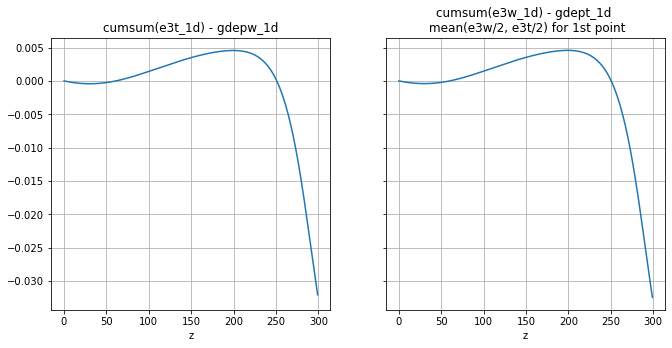

In [22]:
### first of all: compare w depth and cumsum of e3w, 1d fields from grid at rest
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11,5))

(ds_gro.e3t_1d.cumsum("z").shift(z=1, fill_value=0) - ds_gro.gdepw_1d).plot(ax=axs[0])
axs[0].set_title("cumsum(e3t_1d) - gdepw_1d")

(ds_gro.e3w_1d.cumsum("z") - .75*ds_gro.e3w_1d[0] + .25*ds_gro.e3t_1d[0] - ds_gro.gdept_1d).plot(ax=axs[1])
axs[1].set_title("cumsum(e3w_1d) - gdept_1d \n mean(e3w/2, e3t/2) for 1st point")

for ax in axs:
    ax.grid(True)

Bathymetry: compare bathy from file and sum of masked e3t_0

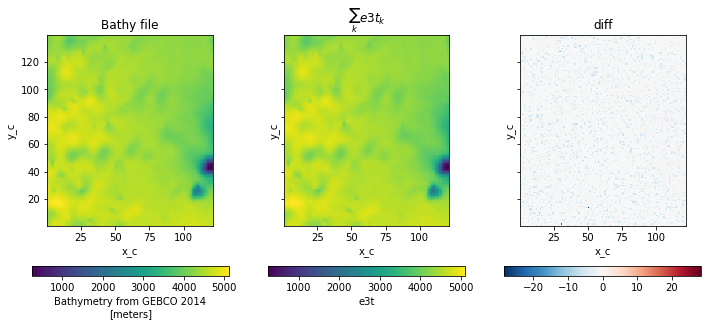

In [23]:
hbot = ds_tot.e3t.where(ds_tot.tmask).sum("z_c")

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
ax = axs[0]
ds_tot.topo.plot(ax=ax, cbar_kwargs={"orientation":"horizontal"})
ax.set_title('Bathy file')
ax = axs[1]
hbot.plot(ax=ax, cbar_kwargs={"orientation":"horizontal"})
ax.set_title(r"$\sum_k e3t_k$")
ax = axs[2]
(hbot - ds_tot.topo).plot(ax=ax, cbar_kwargs={"orientation":"horizontal"})
ax.set_title(r"diff")

for ax in axs:
    ax.set_aspect(1)

Reconstruct ssh from moving z grid (need a topo: test both bathy and sum(e3t): the latter seems to give an accurate result

In [24]:
ssh_hbot = ds_grd.e3t.isel(t=0).where(ds_tot.tmask).sum("z_c")-hbot
ssh_topo = ds_grd.e3t.isel(t=0).where(ds_tot.tmask).sum("z_c")-ds_tot.topo
#ssh_e3t = (ds_grd.e3t.isel(t=0) -  ds_gro.e3t_0.rename({"z":"z_c"})).where(ds_tot.tmask).sum("z_c")

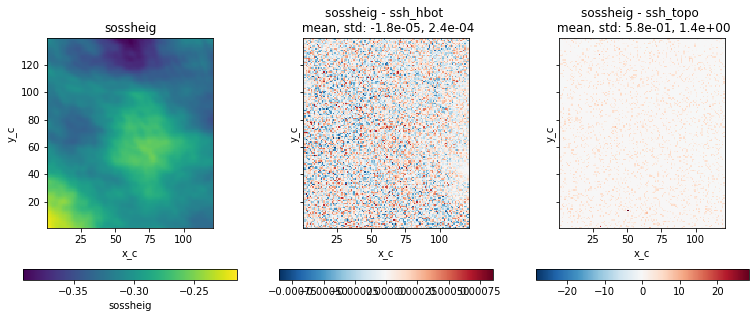

In [25]:

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(13,5))
ax = axs[0]
ds_tot.sossheig.isel(t=0).plot(ax=ax, cbar_kwargs={"orientation":"horizontal"})
ax.set_title('sossheig')
ax = axs[1]
data = ds_tot.sossheig.isel(t=0)-ssh_hbot
data.plot(ax=ax, cbar_kwargs={"orientation":"horizontal"})
ax.set_title('sossheig - ssh_hbot \n mean, std: {:.1e}, {:.1e}'\
             .format(float(data.mean()), float(data.std())))
ax = axs[2]
data = ds_tot.sossheig.isel(t=0)-ssh_topo
data.plot(ax=ax, cbar_kwargs={"orientation":"horizontal"})
ax.set_title('sossheig - ssh_topo \n mean, std: {:.1e}, {:.1e}'\
             .format(float(data.mean()), float(data.std())))
#ax = axs[1,1]
#data = ds_tot.sossheig.isel(t=0)-ssh_e3t
#data.plot(ax=ax)
#ax.set_title('sossheig - ssh_e3t -- mean, std: {:.1e}, {:.1e}'\
#             .format(float(data.mean()), float(data.std())))

for ax in axs.ravel():
    ax.set_aspect(1)